In [ ]:
%config Completer.use_jedi = False
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import cv2
import random
import os
import imageio.v2 as imageio
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from collections import Counter

In [ ]:

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, RepeatedStratifiedKFold
from imblearn.over_sampling import SMOTE

In [ ]:

import tensorflow as tf
import keras
from keras import regularizers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.applications.resnet import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img, img_to_array, array_to_img, plot_model
from keras.callbacks import EarlyStopping



In [ ]:
dir= '/content/drive/MyDrive/Dataset_DL/DL project/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset'

categories = ['Bengin cases', 'Malignant cases', 'Normal cases']


In [ ]:


size_data = {}

for i in categories:
    path = os.path.join(dir, i)
    class_num = categories.index(i)
    temp_dict = {}

    for file in os.listdir(path):
        filepath = os.path.join(path, file)


        img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)

        height, width = img.shape

        if f'{height} x {width}' in temp_dict:
            temp_dict[f'{height} x {width}'] += 1
        else:
            temp_dict[f'{height} x {width}'] = 1

    size_data[i] = temp_dict

size_data


{'Bengin cases': {'512 x 512': 120},
 'Malignant cases': {'512 x 512': 501,
  '404 x 511': 1,
  '512 x 801': 28,
  '512 x 623': 31},
 'Normal cases': {'512 x 512': 415, '331 x 506': 1}}

Bengin cases


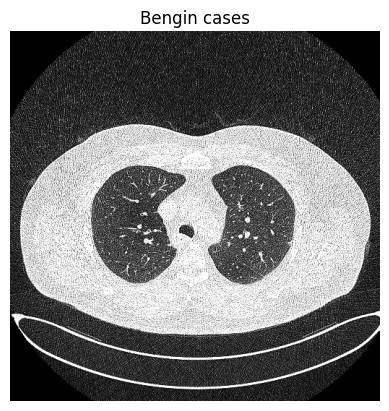

Malignant cases


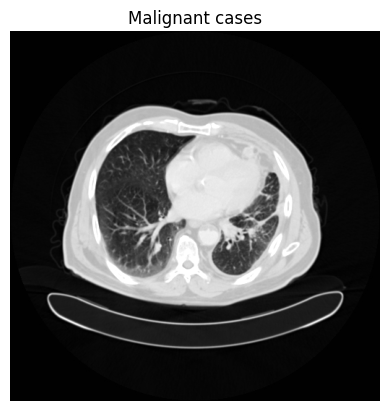

Normal cases


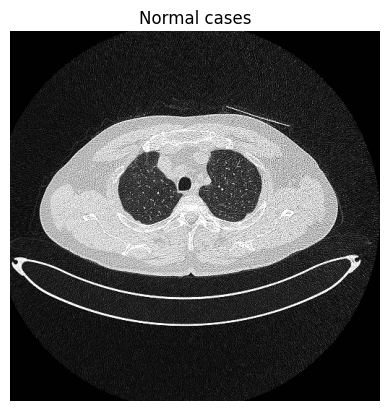

In [ ]:

for category in categories:
    path = os.path.join(dir, category)
    class_num = categories.index(category)

    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        print(category)

        img = cv2.imread(filepath, 0)

        plt.imshow(img, cmap='gray')
        plt.title(category)
        plt.axis('off')
        plt.show()

        break


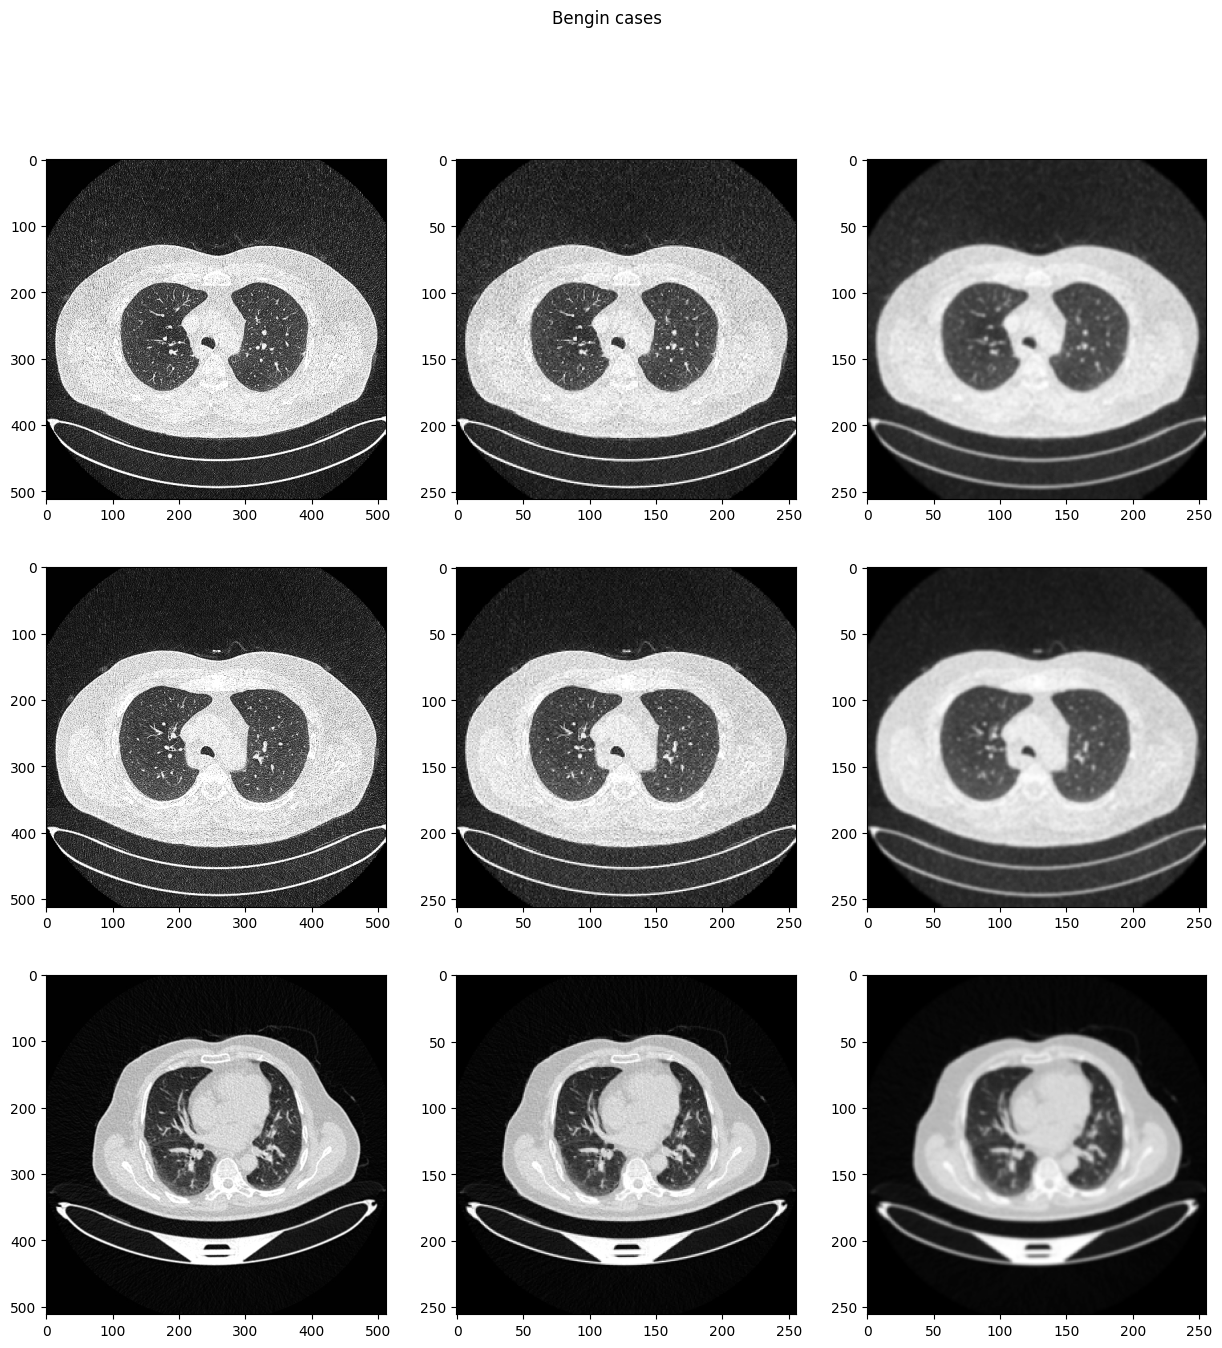

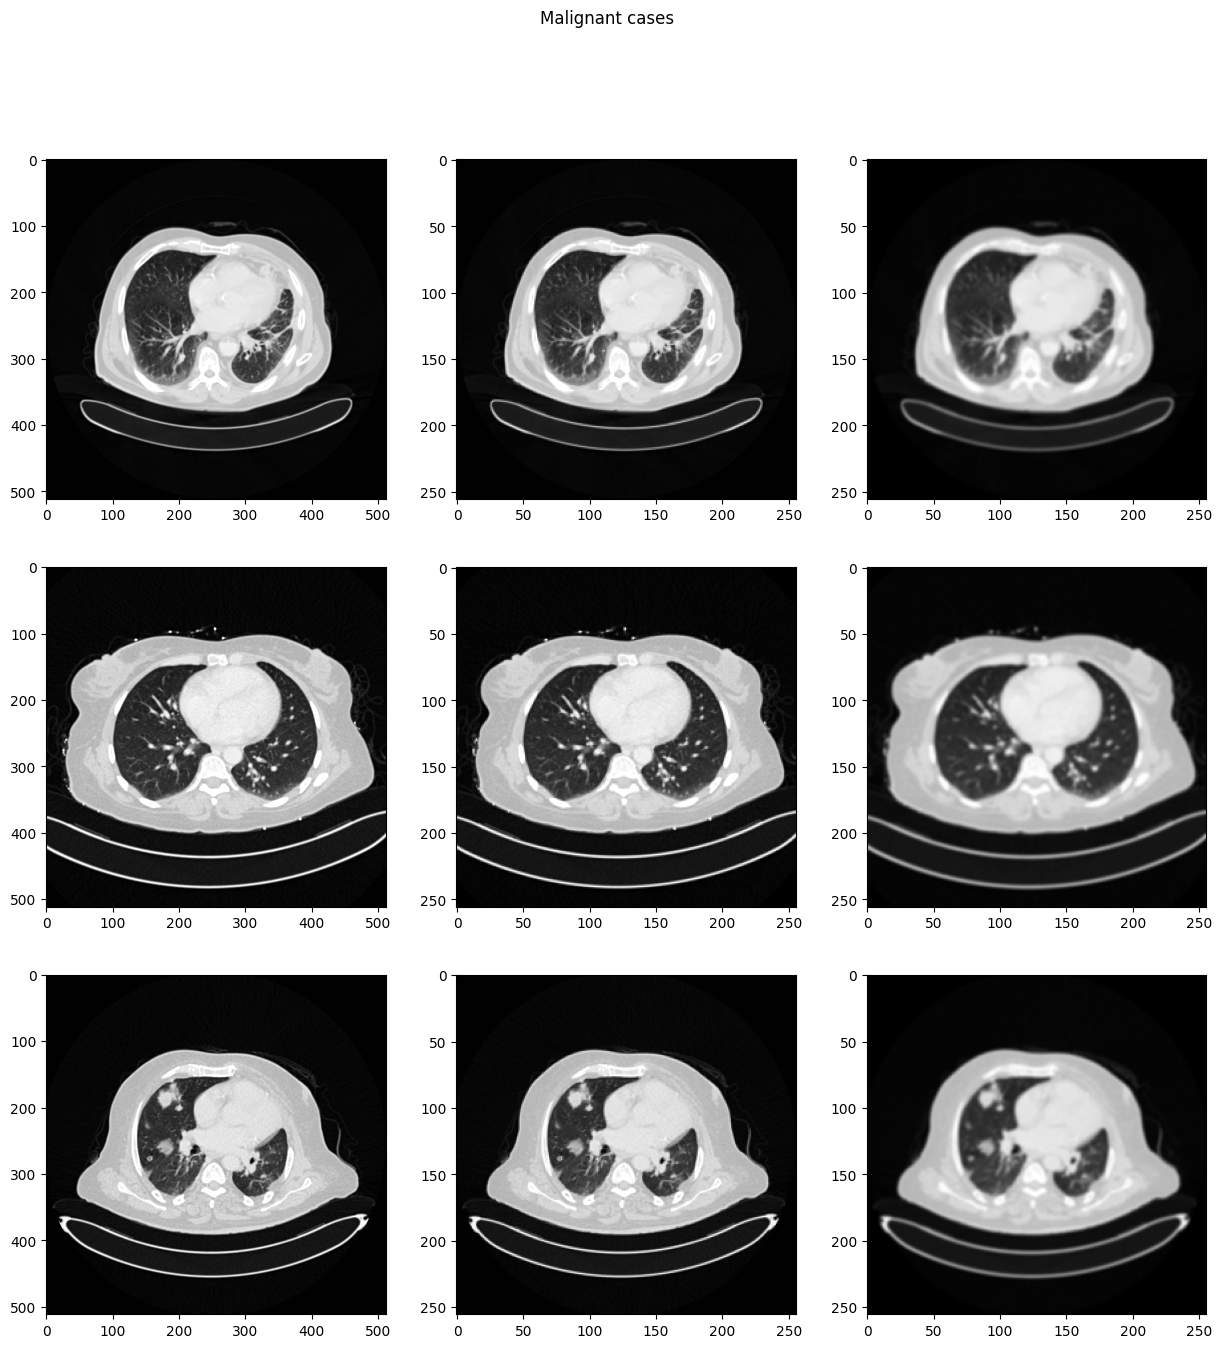

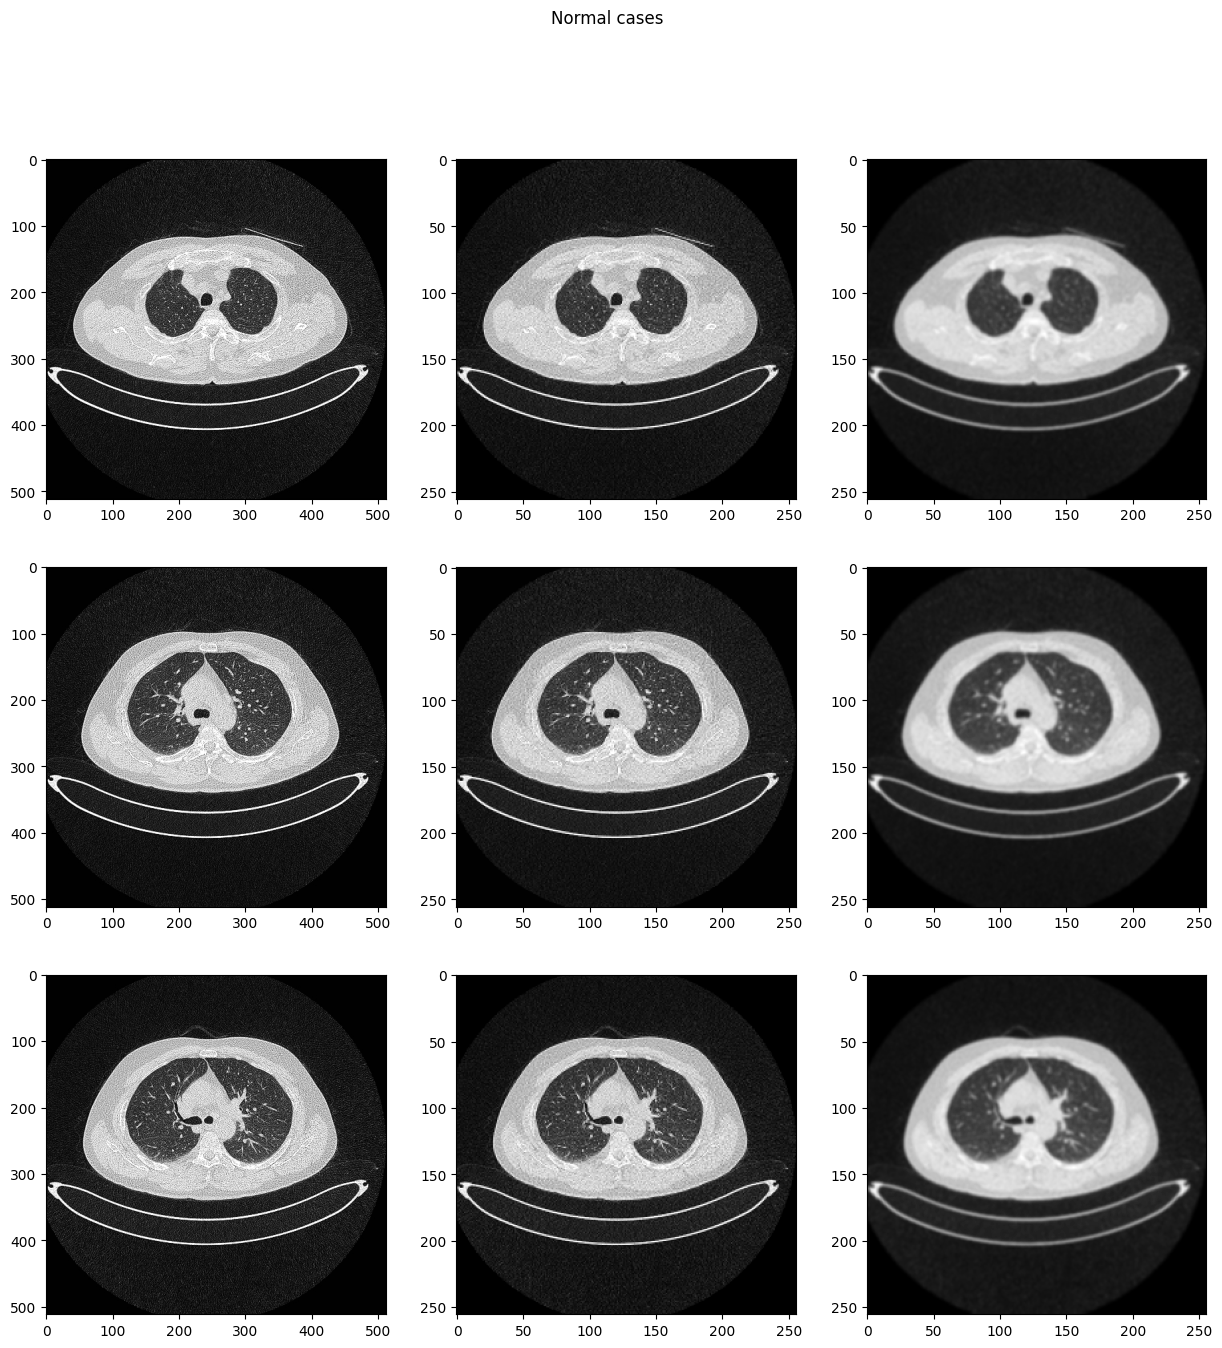

In [ ]:
img_size = 256
for i in categories:
    cnt, samples = 0, 3
    fig, ax = plt.subplots(samples, 3, figsize=(15, 15))
    fig.suptitle(i)

    path = os.path.join(dir, i)
    class_num = categories.index(i)
    for curr_cnt, file in enumerate(os.listdir(path)):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0)
        img0 = cv2.resize(img, (img_size, img_size))
        img1 = cv2.GaussianBlur(img0, (5, 5), 0)
        ax[cnt, 0].imshow(img, cmap='gray')
        ax[cnt, 1].imshow(img0, cmap='gray')
        ax[cnt, 2].imshow(img1, cmap='gray')
        cnt += 1
        if cnt == samples:
            break

plt.show()


In [ ]:
data = []
img_size = 256

for i in categories:
    path = os.path.join(dir, i)
    class_num = categories.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0)
        img = cv2.resize(img, (img_size, img_size))
        data.append([img, class_num])

random.shuffle(data)

X, y = [], []
for feature, label in data:
    X.append(feature)
    y.append(label)

print('X length:', len(X))
print('y counts:', Counter(y))


X = np.array(X).reshape(-1, img_size, img_size, 1)
X = X / 255.0
y = np.array(y)

X length: 1097
y counts: Counter({1: 561, 2: 416, 0: 120})


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=10)

print('Train length:', len(X_train), X_train.shape)
print('Test length:', len(X_valid), X_valid.shape)

Train length: 822 (822, 256, 256, 1)
Test length: 275 (275, 256, 256, 1)


In [ ]:
print(Counter(y_train), Counter(y_valid))

Counter({1: 422, 2: 312, 0: 88}) Counter({1: 139, 2: 104, 0: 32})


In [ ]:
print(len(X_train), X_train.shape)

X_train = X_train.reshape(X_train.shape[0], img_size*img_size*1)

print(len(X_train), X_train.shape)

822 (822, 256, 256, 1)
822 (822, 65536)


In [ ]:
print('Before SMOTE:', Counter(y_train))
smote = SMOTE()
X_train_sampled, y_train_sampled = smote.fit_resample(X_train, y_train)
print('After SMOTE:', Counter(y_train_sampled))


Before SMOTE: Counter({1: 422, 2: 312, 0: 88})
After SMOTE: Counter({1: 422, 2: 422, 0: 422})


In [ ]:
X_train = X_train.reshape(X_train.shape[0], img_size, img_size, 1)
X_train_sampled = X_train_sampled.reshape(X_train_sampled.shape[0], img_size, img_size, 1)

print(len(X_train), X_train.shape)
print(len(X_train_sampled), X_train_sampled.shape)

822 (822, 256, 256, 1)
1266 (1266, 256, 256, 1)


In [ ]:
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()

In [ ]:
train_generator = train_datagen.flow(X_train, y_train, batch_size=8, shuffle=True)
validation_generator = val_datagen.flow(X_valid, y_valid, batch_size=8, shuffle=True)

In [ ]:

resnet_base = ResNet50(weights=None, include_top=False, input_shape=X_train.shape[1:])
for layer in resnet_base.layers:
    layer.trainable = False


In [ ]:

model = Sequential()
model.add(resnet_base)


model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23581440  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 128)               16777344  
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 40359171 (153.96 MB)
Trainable params: 16777731 (64.00 MB)
Non-trainable params: 23581440 (89.96 MB)
_________________________________________________________________


In [ ]:

callback = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator, epochs=20, validation_data=validation_generator, callbacks=[callback])

Epoch 1/20
103/103 [==============================] - 22s 91ms/step - loss: 0.8850 - accuracy: 0.6314 - val_loss: 0.5813 - val_accuracy: 0.7745
Epoch 2/20
103/103 [==============================] - 6s 54ms/step - loss: 0.5593 - accuracy: 0.7810 - val_loss: 0.4732 - val_accuracy: 0.8255
Epoch 3/20
103/103 [==============================] - 7s 68ms/step - loss: 0.4055 - accuracy: 0.8564 - val_loss: 0.3708 - val_accuracy: 0.8618
Epoch 4/20
103/103 [==============================] - 7s 63ms/step - loss: 0.3943 - accuracy: 0.8710 - val_loss: 0.4843 - val_accuracy: 0.7818
Epoch 5/20
103/103 [==============================] - 7s 70ms/step - loss: 0.2414 - accuracy: 0.9270 - val_loss: 0.2619 - val_accuracy: 0.9527
Epoch 6/20
103/103 [==============================] - 6s 56ms/step - loss: 0.2135 - accuracy: 0.9270 - val_loss: 0.2124 - val_accuracy: 0.9345
Epoch 7/20
103/103 [==============================] - 7s 68ms/step - loss: 0.2782 - accuracy: 0.9088 - val_loss: 0.6184 - val_accuracy: 0.705

In [ ]:
y_pred = model.predict(X_valid, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_bool))
print(confusion_matrix(y_true=y_valid, y_pred=y_pred_bool))

9/9 [==============================] - 4s 216ms/step
              precision    recall  f1-score   support

           0       1.00      0.06      0.12        32
           1       1.00      0.94      0.97       139
           2       0.73      1.00      0.84       104

    accuracy                           0.86       275
   macro avg       0.91      0.67      0.64       275
weighted avg       0.90      0.86      0.82       275

[[  2   0  30]
 [  0 130   9]
 [  0   0 104]]


In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_valid, y_pred_bool)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.86


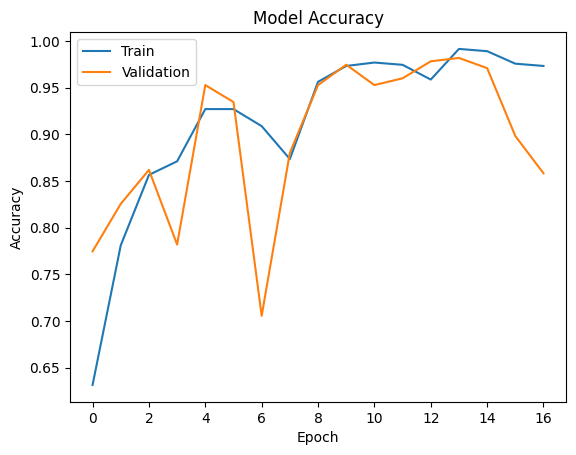

In [ ]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

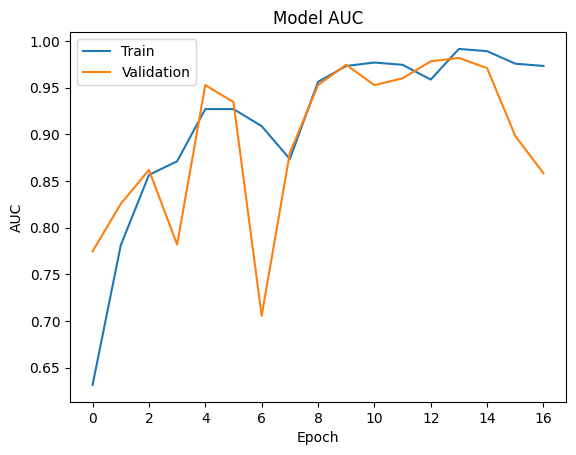

In [ ]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend()
plt.show()

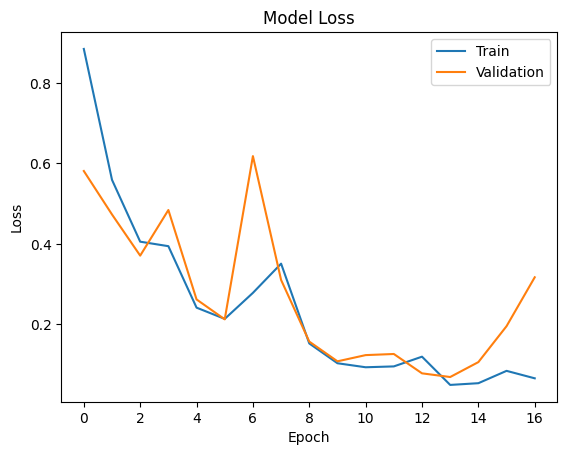

In [ ]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader


In [ ]:
# Name0 = os.listdir(dir)
# print(Name0)

['IQ-OTH_NCCD lung cancer dataset.txt', 'Normal cases', 'Malignant cases', 'Bengin cases']


In [ ]:
# Name1=['Normal cases', 'Bengin cases', 'Malignant cases']
# Name=sorted(Name1)
# Name

['Bengin cases', 'Malignant cases', 'Normal cases']

In [ ]:
N=list(range(len(categories)))
normal_mapping=dict(zip(categories,N))
reverse_mapping=dict(zip(N,categories))

In [ ]:
dataset=[]
for i in tqdm(range(len(categories))):
    path=os.path.join(dir,categories[i])
    for im in os.listdir(path):
        labeli=normal_mapping[categories[i]]
        img1=cv2.imread(os.path.join(path,im))
        img2=cv2.resize(img1,dsize=(100,100),interpolation=cv2.INTER_CUBIC)
        img3=img2.astype(np.float32)
        image=torch.from_numpy(img3).permute(2,0,1) ###
        dataset+=[[image,labeli]]

100%|██████████| 3/3 [00:09<00:00,  3.11s/it]


In [ ]:
dataset[100]

[tensor([[[38., 38., 38.,  ..., 38., 38., 38.],
          [38., 38., 38.,  ..., 38., 38., 38.],
          [38., 38., 38.,  ..., 38., 38., 38.],
          ...,
          [38., 38., 38.,  ..., 38., 38., 38.],
          [38., 38., 38.,  ..., 38., 38., 38.],
          [38., 38., 38.,  ..., 38., 38., 38.]],
 
         [[38., 38., 38.,  ..., 38., 38., 38.],
          [38., 38., 38.,  ..., 38., 38., 38.],
          [38., 38., 38.,  ..., 38., 38., 38.],
          ...,
          [38., 38., 38.,  ..., 38., 38., 38.],
          [38., 38., 38.,  ..., 38., 38., 38.],
          [38., 38., 38.,  ..., 38., 38., 38.]],
 
         [[38., 38., 38.,  ..., 38., 38., 38.],
          [38., 38., 38.,  ..., 38., 38., 38.],
          [38., 38., 38.,  ..., 38., 38., 38.],
          ...,
          [38., 38., 38.,  ..., 38., 38., 38.],
          [38., 38., 38.,  ..., 38., 38., 38.],
          [38., 38., 38.,  ..., 38., 38., 38.]]]),
 0]

In [ ]:

img, label = dataset[100]
print(img.shape)
print(label)

torch.Size([3, 100, 100])
0


In [ ]:
def show_image(img,label):
    img2=img.permute(1,2,0).numpy().astype(int)
    print(img2.shape)
    print(reverse_mapping[label])
    plt.imshow(img2)


(100, 100, 3)
Bengin cases


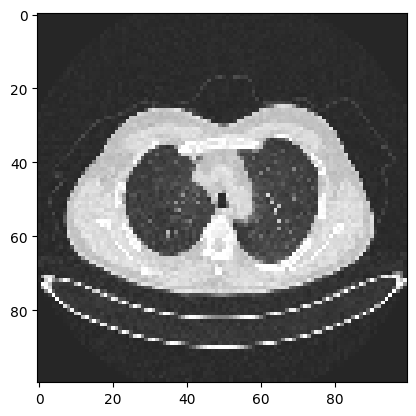

In [ ]:
show_image(*dataset[20])

In [ ]:
torch.manual_seed(20)
val_size = len(dataset)//10
test_size = len(dataset)//5
train_size = len(dataset) - val_size - test_size

In [ ]:
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds), len(test_ds)

(769, 109, 219)

In [ ]:
batch_size = 64
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=4, pin_memory=True)

In [ ]:
m=len(dataset)
M=list(range(m))
random.seed(2021)
random.shuffle(M)

In [ ]:
dataset[0][0]


tensor([[[37., 37., 37.,  ..., 37., 37., 37.],
         [37., 37., 37.,  ..., 37., 37., 37.],
         [37., 37., 37.,  ..., 37., 37., 37.],
         ...,
         [37., 37., 37.,  ..., 37., 37., 37.],
         [37., 37., 37.,  ..., 37., 37., 37.],
         [37., 37., 37.,  ..., 37., 37., 37.]],

        [[37., 37., 37.,  ..., 37., 37., 37.],
         [37., 37., 37.,  ..., 37., 37., 37.],
         [37., 37., 37.,  ..., 37., 37., 37.],
         ...,
         [37., 37., 37.,  ..., 37., 37., 37.],
         [37., 37., 37.,  ..., 37., 37., 37.],
         [37., 37., 37.,  ..., 37., 37., 37.]],

        [[37., 37., 37.,  ..., 37., 37., 37.],
         [37., 37., 37.,  ..., 37., 37., 37.],
         [37., 37., 37.,  ..., 37., 37., 37.],
         ...,
         [37., 37., 37.,  ..., 37., 37., 37.],
         [37., 37., 37.,  ..., 37., 37., 37.],
         [37., 37., 37.,  ..., 37., 37., 37.]]])

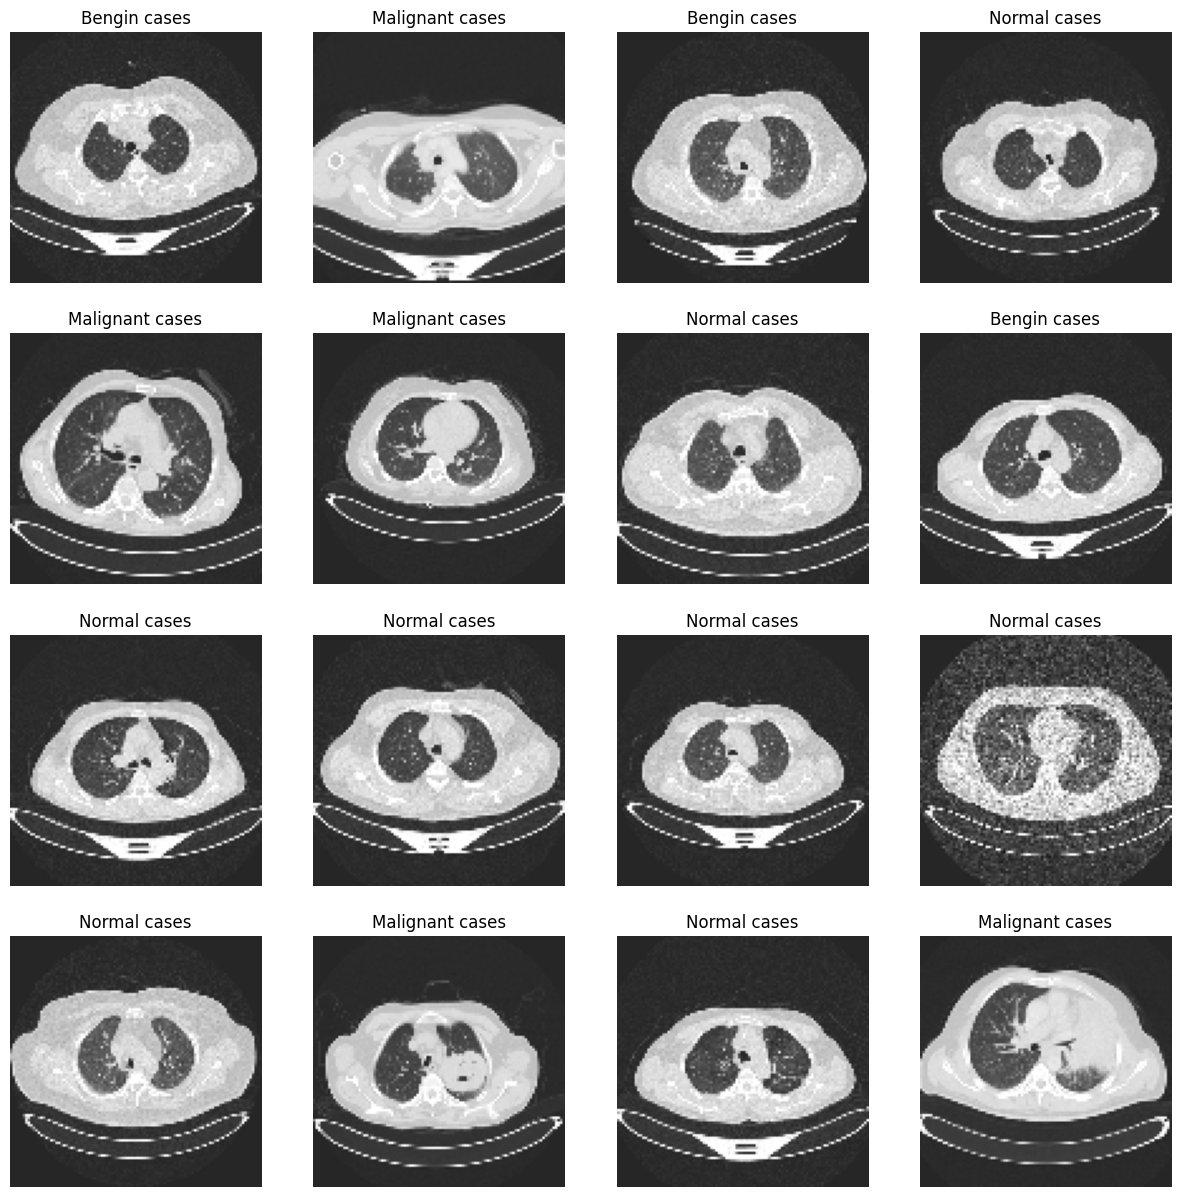

In [ ]:
fig, axs = plt.subplots(4,4,figsize=(15,15))
for i in range(16):
    r=i//4
    c=i%4
    img, label = dataset[M[i]]
    img2=img.permute(1,2,0).numpy().astype(int)
    ax=axs[r][c].axis("off")
    ax=axs[r][c].set_title(reverse_mapping[label])
    ax=axs[r][c].imshow(img2)
plt.show()

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
torch.cuda.is_available()

True

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [ ]:
m=len(dataset)
M=list(range(m))
random.seed(2021)
random.shuffle(M)

In [ ]:
input_size = 3*100*100
output_size = len(categories)

**Conv2d Model**

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                   # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
class CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 100, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(100, 150, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(150, 200, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(200, 200, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(200, 250, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(250, 250, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),
            nn.Linear(36000, 6400),
            nn.ReLU(),
            nn.Linear(6400, 640),
            nn.ReLU(),
            nn.Linear(640, 64),
            nn.ReLU(),
            nn.Linear(64, 8),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(8, output_size))

    def forward(self, xb):
        return self.network(xb)


CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(100, 150, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(150, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(200, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(200, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(250, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=36000, out_features=6400, bias=True)
    (17): ReLU()
    (18): Linear(in_featur

In [ ]:
model = CnnModel()
model.cuda()


CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(100, 150, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(150, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(200, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(200, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(250, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=36000, out_features=6400, bias=True)
    (17): ReLU()
    (18): Linear(in_featur

In [ ]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    break

images.shape: torch.Size([64, 3, 100, 100])
out.shape: torch.Size([64, 3])


In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
to_device(model, device)

CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(100, 150, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(150, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(200, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(200, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(250, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=36000, out_features=6400, bias=True)
    (17): ReLU()
    (18): Linear(in_featur

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = to_device(CnnModel(), device)

In [ ]:
history=[evaluate(model, val_loader)]
history

[{'val_loss': 1.1446337699890137, 'val_acc': 0.37638890743255615}]

In [ ]:
num_epochs = 20
opt_func = torch.optim.Adam
lr = 0.002

In [ ]:
history+= fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

100%|██████████| 13/13 [00:04<00:00,  2.61it/s]


Epoch [0], train_loss: 33.9983, val_loss: 1.1247, val_acc: 0.3764


100%|██████████| 13/13 [00:03<00:00,  3.65it/s]


Epoch [1], train_loss: 1.1290, val_loss: 1.1158, val_acc: 0.3764


100%|██████████| 13/13 [00:03<00:00,  3.65it/s]


Epoch [2], train_loss: 1.1181, val_loss: 1.1062, val_acc: 0.3764


100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch [3], train_loss: 1.0908, val_loss: 1.0973, val_acc: 0.3764


100%|██████████| 13/13 [00:03<00:00,  3.59it/s]


Epoch [4], train_loss: 1.0975, val_loss: 1.0894, val_acc: 0.3764


100%|██████████| 13/13 [00:03<00:00,  3.45it/s]


Epoch [5], train_loss: 1.0879, val_loss: 1.0813, val_acc: 0.3764


100%|██████████| 13/13 [00:03<00:00,  3.48it/s]


Epoch [6], train_loss: 1.0784, val_loss: 1.0736, val_acc: 0.3764


100%|██████████| 13/13 [00:03<00:00,  3.54it/s]


Epoch [7], train_loss: 1.0813, val_loss: 1.0666, val_acc: 0.3764


100%|██████████| 13/13 [00:03<00:00,  3.32it/s]


Epoch [8], train_loss: 1.0541, val_loss: 1.0618, val_acc: 0.3764


100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch [9], train_loss: 1.0732, val_loss: 1.0568, val_acc: 0.3764


100%|██████████| 13/13 [00:04<00:00,  2.88it/s]


Epoch [10], train_loss: 1.0447, val_loss: 1.0526, val_acc: 0.3764


100%|██████████| 13/13 [00:04<00:00,  2.91it/s]


Epoch [11], train_loss: 1.0456, val_loss: 1.0479, val_acc: 0.3764


100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch [12], train_loss: 1.0392, val_loss: 1.0427, val_acc: 0.3764


100%|██████████| 13/13 [00:03<00:00,  3.43it/s]


Epoch [13], train_loss: 1.0327, val_loss: 1.0373, val_acc: 0.3764


100%|██████████| 13/13 [00:04<00:00,  3.10it/s]


Epoch [14], train_loss: 1.0260, val_loss: 1.0325, val_acc: 0.3764


100%|██████████| 13/13 [00:03<00:00,  3.47it/s]


Epoch [15], train_loss: 1.0200, val_loss: 1.0280, val_acc: 0.4977


100%|██████████| 13/13 [00:03<00:00,  3.45it/s]


Epoch [16], train_loss: 1.0142, val_loss: 1.0237, val_acc: 0.4977


100%|██████████| 13/13 [00:03<00:00,  3.59it/s]


Epoch [17], train_loss: 1.0473, val_loss: 1.0200, val_acc: 0.4977


100%|██████████| 13/13 [00:03<00:00,  3.45it/s]


Epoch [18], train_loss: 1.0052, val_loss: 1.0177, val_acc: 0.4977


100%|██████████| 13/13 [00:03<00:00,  3.56it/s]


Epoch [19], train_loss: 1.0014, val_loss: 1.0145, val_acc: 0.4977


In [ ]:
history+= fit(num_epochs, lr/10, model, train_dl, val_dl, opt_func)

100%|██████████| 13/13 [00:03<00:00,  3.50it/s]


Epoch [0], train_loss: 1.0058, val_loss: 1.0141, val_acc: 0.4977


100%|██████████| 13/13 [00:03<00:00,  3.60it/s]


Epoch [1], train_loss: 0.9986, val_loss: 1.0137, val_acc: 0.4977


100%|██████████| 13/13 [00:03<00:00,  3.37it/s]


Epoch [2], train_loss: 0.9980, val_loss: 1.0133, val_acc: 0.4977


100%|██████████| 13/13 [00:03<00:00,  3.44it/s]


Epoch [3], train_loss: 1.0412, val_loss: 1.0129, val_acc: 0.4977


100%|██████████| 13/13 [00:03<00:00,  3.42it/s]


Epoch [4], train_loss: 0.9971, val_loss: 1.0126, val_acc: 0.4977


100%|██████████| 13/13 [00:03<00:00,  3.42it/s]


Epoch [5], train_loss: 0.9967, val_loss: 1.0123, val_acc: 0.4977


100%|██████████| 13/13 [00:03<00:00,  3.53it/s]


Epoch [6], train_loss: 0.9962, val_loss: 1.0119, val_acc: 0.4977


100%|██████████| 13/13 [00:03<00:00,  3.39it/s]


Epoch [7], train_loss: 0.9957, val_loss: 1.0115, val_acc: 0.4977


100%|██████████| 13/13 [00:03<00:00,  3.58it/s]


Epoch [8], train_loss: 1.0030, val_loss: 1.0112, val_acc: 0.4977


100%|██████████| 13/13 [00:03<00:00,  3.57it/s]


Epoch [9], train_loss: 1.0401, val_loss: 1.0109, val_acc: 0.4977


100%|██████████| 13/13 [00:03<00:00,  3.47it/s]


Epoch [10], train_loss: 1.0399, val_loss: 1.0107, val_acc: 0.4977


100%|██████████| 13/13 [00:03<00:00,  3.56it/s]


Epoch [11], train_loss: 1.0398, val_loss: 1.0105, val_acc: 0.4977


100%|██████████| 13/13 [00:03<00:00,  3.43it/s]


Epoch [12], train_loss: 1.0020, val_loss: 1.0104, val_acc: 0.4977


100%|██████████| 13/13 [00:03<00:00,  3.51it/s]


Epoch [13], train_loss: 0.9937, val_loss: 1.0101, val_acc: 0.4977


100%|██████████| 13/13 [00:03<00:00,  3.61it/s]


Epoch [14], train_loss: 1.0015, val_loss: 1.0098, val_acc: 0.4977


100%|██████████| 13/13 [00:03<00:00,  3.47it/s]


Epoch [15], train_loss: 1.0012, val_loss: 1.0096, val_acc: 0.4977


100%|██████████| 13/13 [00:03<00:00,  3.46it/s]


Epoch [16], train_loss: 1.0008, val_loss: 1.0093, val_acc: 0.4977


100%|██████████| 13/13 [00:03<00:00,  3.49it/s]


Epoch [17], train_loss: 0.9923, val_loss: 1.0090, val_acc: 0.4977


100%|██████████| 13/13 [00:03<00:00,  3.45it/s]


Epoch [18], train_loss: 0.9919, val_loss: 1.0087, val_acc: 0.4977


100%|██████████| 13/13 [00:03<00:00,  3.51it/s]


Epoch [19], train_loss: 0.9998, val_loss: 1.0084, val_acc: 0.4977


In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

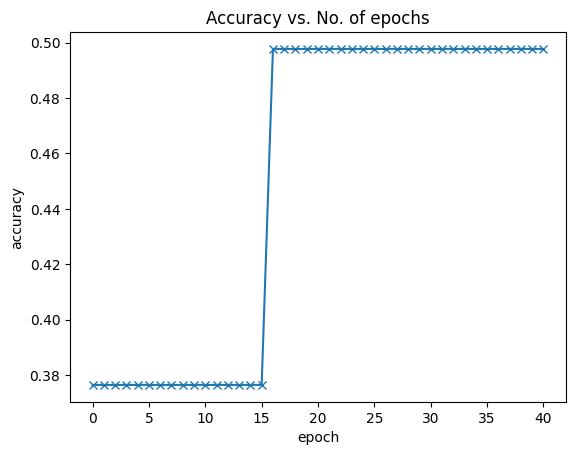

In [ ]:
plot_accuracies(history)

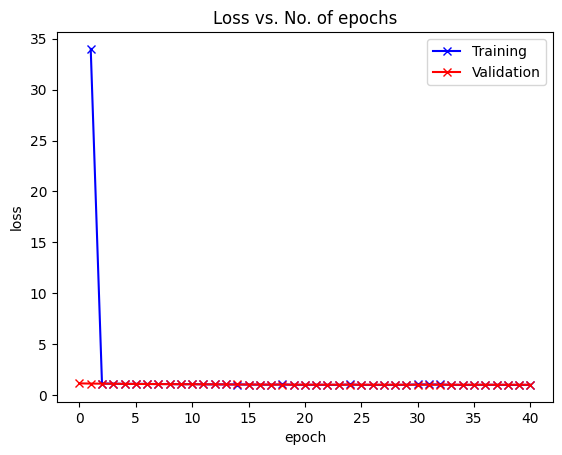

In [ ]:
plot_losses(history)